In [1]:
# AUTORELOAD MAGIC
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import matplotlib.pyplot as plt
import time

### sparse majority (21, 5) 

In [4]:

# Create a different dataset for every 'nondeterministic' value in this list
# Note that _sometimes_ this means bitflip rate, but not always
p_bitflips = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.49]
# p_bitflips = [0.45]
all_H = []
all_mle = []

def sparse_majority_k5(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_majority_k_n(n_bits, 5, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

# Generate data with bitflip values
seed = 1234 
n_data = 1000000 # ~maximum~ amount of data to analyze
inc = 50000 # increment at which to check convergence
assert inc < n_data
n_bits = 6 # HACK: We only consider the bits that actually contribute to the majority vote
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle_noisy = []
all_mle_noiseless = []

for i in range(len(p_bitflips)):
    t0 = time.time()
    X, Z, idx = sparse_majority_k5(n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    # compute the mle performance and the mle lookup table for this dataset
    H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle_noisy.append(mle_results)
    # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
    t0 = time.time()
    mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
    print("computed noiseless MLE for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_mle_noiseless.append(mle_noiseless)

generated data for p_bitflip =  0.0  took  5.148324012756348  seconds
computed entropy for p_bitflip =  0.0  took  2.0400893688201904  seconds
computed noiseless MLE for p_bitflip =  0.0  took  2.849982261657715  seconds
generated data for p_bitflip =  0.05  took  4.433598279953003  seconds
computed entropy for p_bitflip =  0.05  took  2.048414468765259  seconds
computed noiseless MLE for p_bitflip =  0.05  took  2.827298879623413  seconds
generated data for p_bitflip =  0.1  took  5.779256343841553  seconds
computed entropy for p_bitflip =  0.1  took  2.167417049407959  seconds


KeyboardInterrupt: 

In [25]:
def compute_mle_with_lookup(X, lookup):
    """Given a trained lookup table of {tuple(bitstring): next bit}, compute MLE accuracy"""
    n_data, n_bits = X.shape
    keys, counts = np.unique(X, axis=0, return_counts=True)
    counts = counts / n_data
    out = 0
    for k, c in zip(keys, counts):
        prefix = tuple([int(s) for s in k[:-1]])
        next_bit = lookup.get(prefix)
        if next_bit is not None:
            # print(prefix, lookup[prefix], k[-1], out)
            out += c * (1 - k[-1] ^ lookup[prefix])
        else:
            print("prefix not found: ", prefix)
    return out
lookup = lookup_results[-1]

compute_mle_with_lookup(X, lookup)

np.float64(0.9999999999999999)

In [14]:
# make a lookup table specifically to memorize our specific noisy training set
lookuptable_benchmarks = np.zeros_like(p_bitflips)
# lookuptable_benchmarks = []
# for i in range(len(p_bitflips)):
#     benchX, benchZ, idx = sparse_majority_k5(2000, n_bits, p_bitflips[i], seed)
#     # print("idx=", idx)
#     # train a lookup table on the noisy train data from our own experiments
#     _, benchmle, bench_lookup = entropy.empirical_entropy_estimate(benchZ)
#     mle_noisy_benchmark = entropy.compute_mle_with_lookup(benchZ, bench_lookup[0])
#     lookuptable_benchmarks.append(mle_noisy_benchmark)

### Plot the optimal performances, etc.

[np.float64(1.0000000000000002), np.float64(0.9144926315789473), np.float64(0.8437547368421051), np.float64(0.7844536842105263), np.float64(0.7333042105263157), np.float64(0.6880894736842105), np.float64(0.6464305263157895), np.float64(0.60848), np.float64(0.5716336842105264), np.float64(0.5354810526315791), np.float64(0.5024484210526315)]
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19


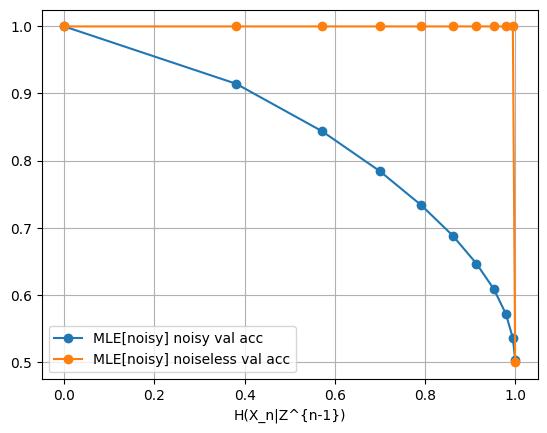

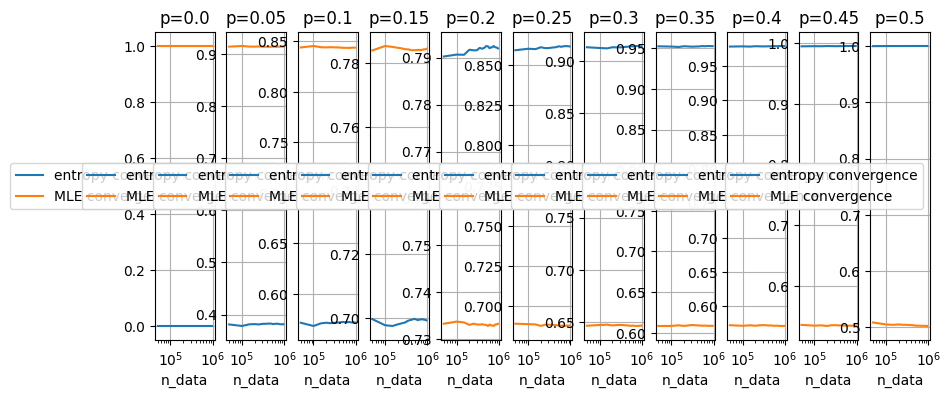

In [19]:
entropy.plot_entropy_and_convergence(all_H, all_mle_noisy, all_mle_noiseless, lookuptable_benchmarks, p_bitflips, intermediate_idx, xcoord='entropy')